# Custom model and transform

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/etna-team/etna/master?filepath=examples/301-custom_transform_and_model.ipynb)

This notebook contains the simple examples of custom model and transform that can be added to the ETNA framework.

**Table of contents**

* [What is transform and how it works](#chapter1)  
* [Custom transform](#chapter2)
    * [Per-segment custom transform](#section_2_1)
    * [Multi-segment custom transform](#section_2_2)
* [Custom model](#chapter3)
    * [Creating a new model from scratch](#section_3_1)
    * [Creating a new model using sklearn interface](#section_3_2)

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
from copy import deepcopy
from typing import List

import numpy as np
import pandas as pd

from etna.analysis import plot_backtest
from etna.datasets.tsdataset import TSDataset
from etna.metrics import MAE
from etna.pipeline import Pipeline
from etna.transforms import DateFlagsTransform
from etna.transforms import LagTransform
from etna.transforms import LinearTrendTransform
from etna.transforms import SegmentEncoderTransform

## 1. What is transform and how it works <a class="anchor" id="chapter1"></a>

Our library works with the special data structure `TSDataset`. So, before starting, we need to convert the classical `DataFrame` to `TSDataset`.

In [3]:
df = pd.read_csv("data/example_dataset.csv")
df["timestamp"] = pd.to_datetime(df["timestamp"])
init_ts = TSDataset(df, freq="D")

ts = deepcopy(init_ts)

ts.head(5)

segment,segment_a,segment_b,segment_c,segment_d
feature,target,target,target,target
timestamp,,,,
2019-01-01,170,102,92,238
2019-01-02,243,123,107,358
2019-01-03,267,130,103,366
2019-01-04,287,138,103,385
2019-01-05,279,137,104,384


Let's look at the original view of data

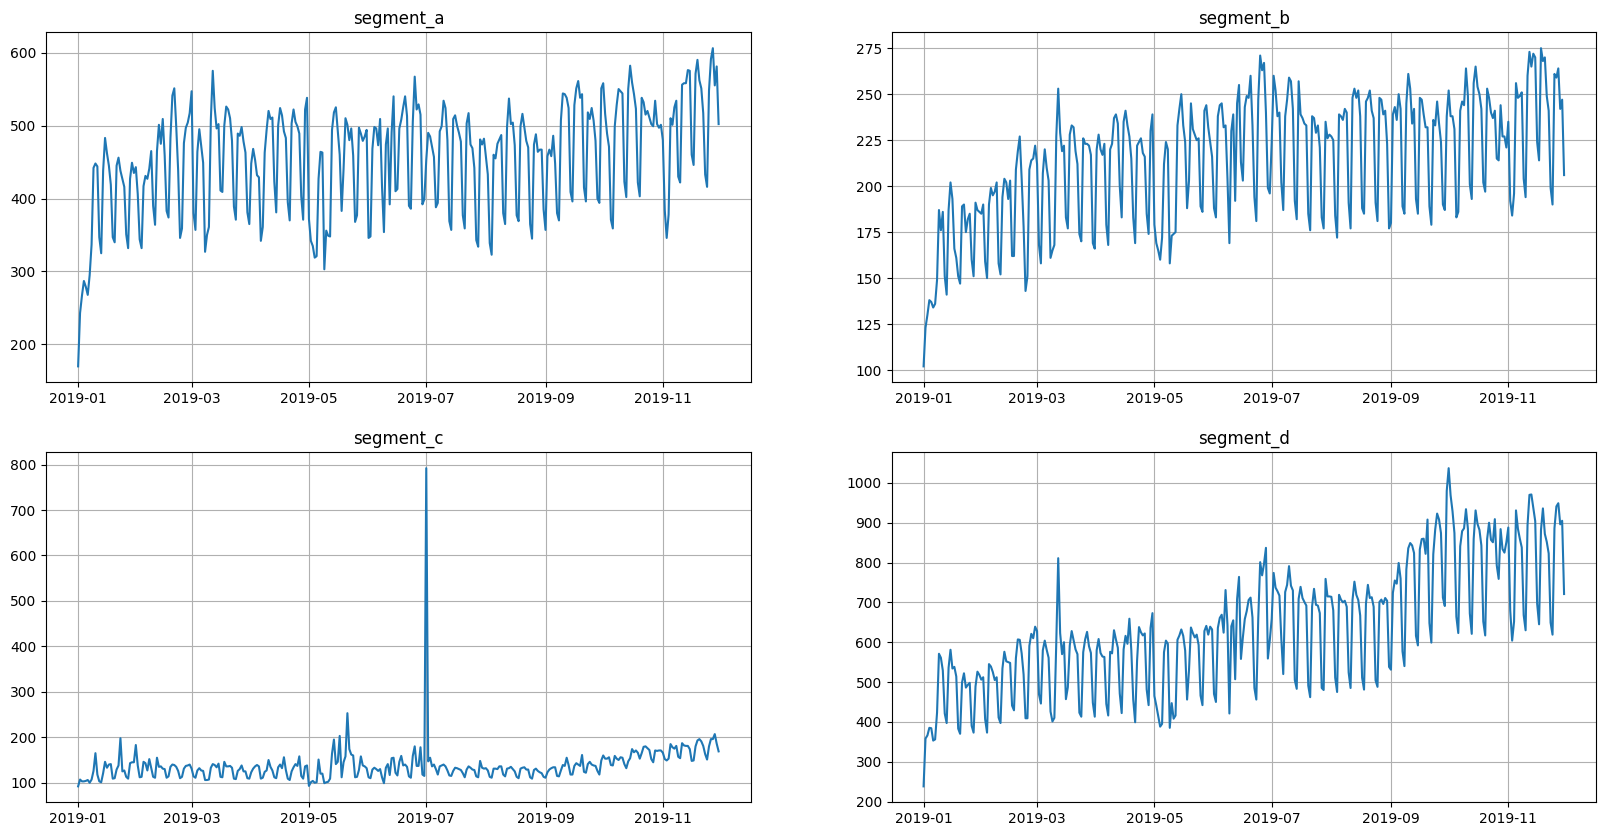

In [4]:
ts.plot()

Transform is the manipulation of data to extract new features or update created ones. 

In ETNA, transforms can change column values or add new ones. 

For example:

* `DateFlagsTransform` - adds columns with information about the date (day number, is the day a weekend, etc.) .
* `LinearTrendTransform` - subtracts a linear trend from the series (changes it).

In [5]:
dates = DateFlagsTransform(day_number_in_week=True, day_number_in_month=False, out_column="dateflag")
detrend = LinearTrendTransform(in_column="target")

ts.fit_transform([dates, detrend])

ts.head(3)

segment                      segment_a                                  \
feature    dateflag_day_number_in_week dateflag_is_weekend      target   
timestamp                                                                
2019-01-01                           1               False -236.276825   
2019-01-02                           2               False -163.575877   
2019-01-03                           3               False -139.874928   

segment                      segment_b                                 \
feature    dateflag_day_number_in_week dateflag_is_weekend     target   
timestamp                                                               
2019-01-01                           1               False -79.162964   
2019-01-02                           2               False -58.358457   
2019-01-03                           3               False -51.553950   

segment                      segment_c                                 \
feature    dateflag_day_number_in_week dateflag_is_weekend     target   
timestamp                                                               
2019-01-01                           1               False -26.743498   
2019-01-02                           2               False -11.861383   
2019-01-03                           3               False -15.979267   

segment                      segment_d                                  
feature    dateflag_day_number_in_week dateflag_is_weekend      target  
timestamp                                                               
2019-01-01                           1               False -194.070140  
2019-01-02                           2               False  -75.292679  
2019-01-03                           3               False  -68.515217

In addition to the appearance of a new column, the values ​​in the target column have changed. This can be seen from the graphs.

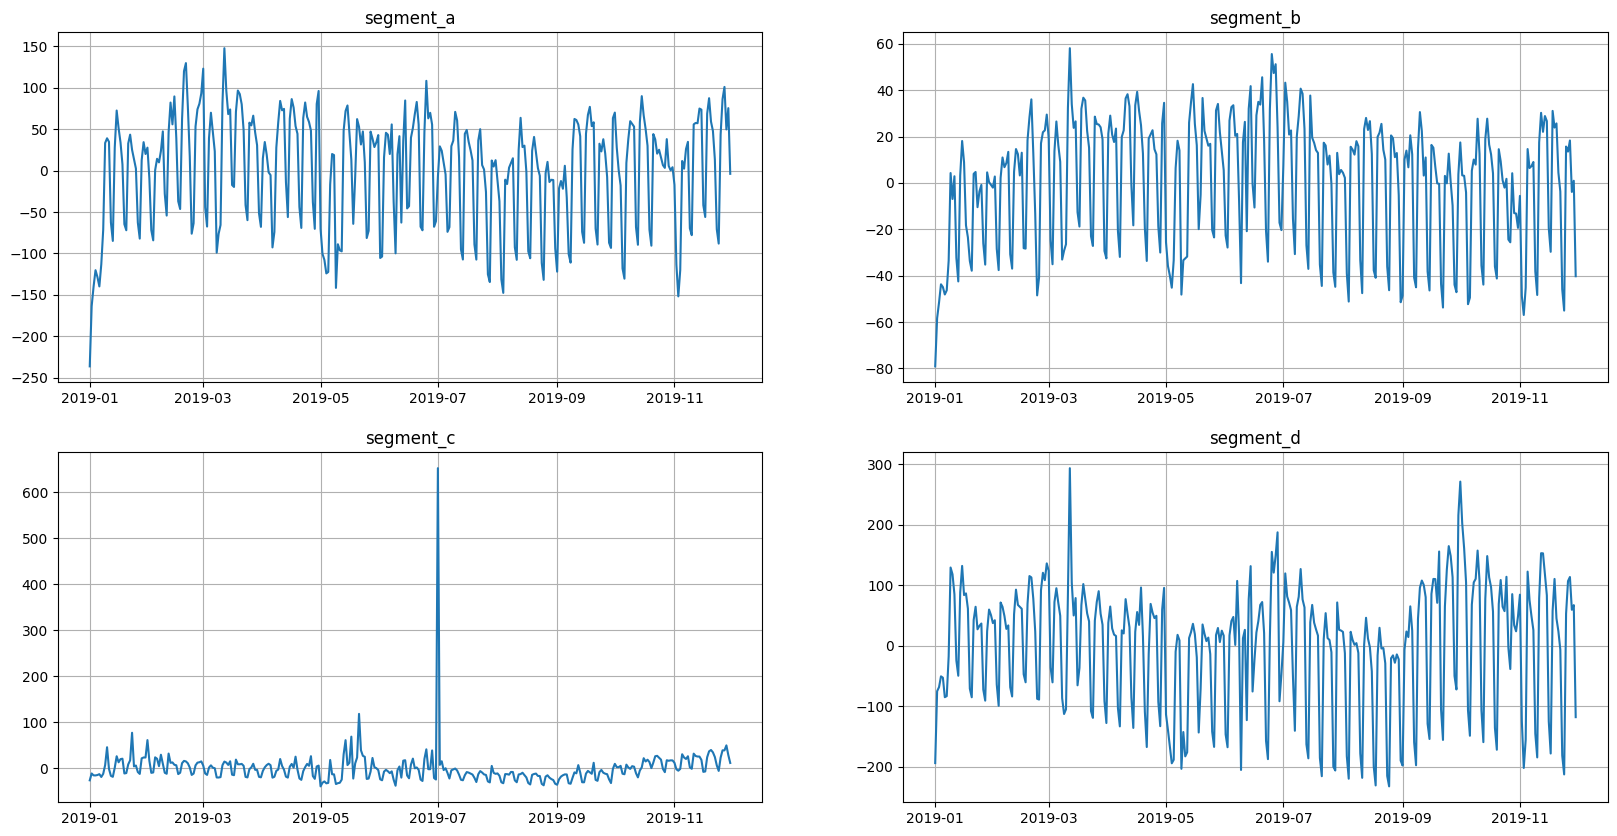

In [6]:
ts.plot()

In [7]:
ts.inverse_transform([dates, detrend])
ts.head(3)

segment                      segment_a                             \
feature    dateflag_day_number_in_week dateflag_is_weekend target   
timestamp                                                           
2019-01-01                           1               False  170.0   
2019-01-02                           2               False  243.0   
2019-01-03                           3               False  267.0   

segment                      segment_b                             \
feature    dateflag_day_number_in_week dateflag_is_weekend target   
timestamp                                                           
2019-01-01                           1               False  102.0   
2019-01-02                           2               False  123.0   
2019-01-03                           3               False  130.0   

segment                      segment_c                             \
feature    dateflag_day_number_in_week dateflag_is_weekend target   
timestamp                                                           
2019-01-01                           1               False   92.0   
2019-01-02                           2               False  107.0   
2019-01-03                           3               False  103.0   

segment                      segment_d                             
feature    dateflag_day_number_in_week dateflag_is_weekend target  
timestamp                                                          
2019-01-01                           1               False  238.0  
2019-01-02                           2               False  358.0  
2019-01-03                           3               False  366.0

Now the data is back in its original form

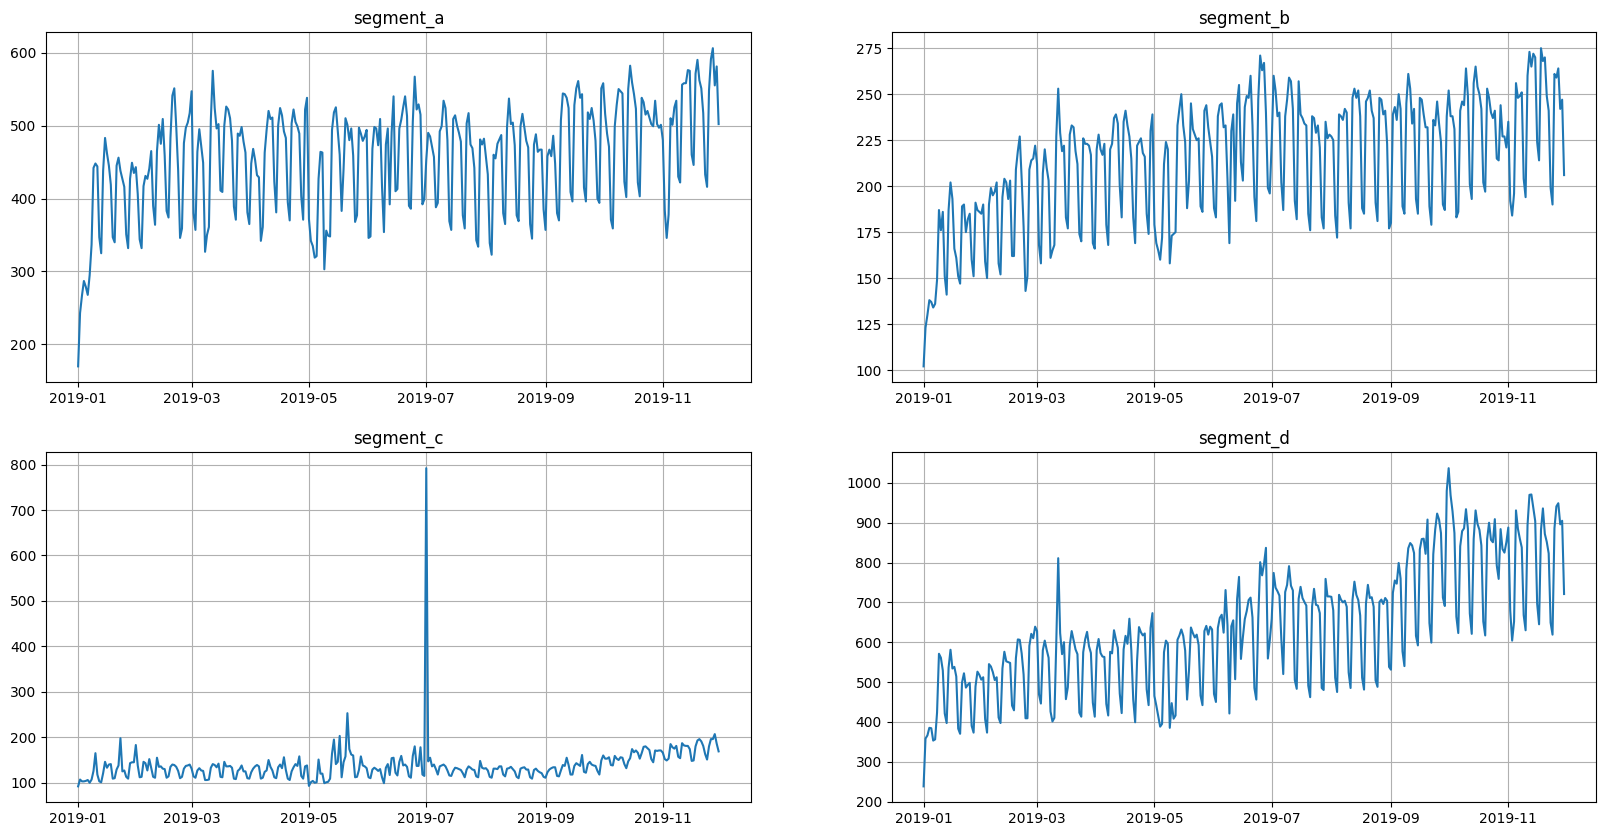

In [8]:
ts.plot()

## 2. Custom transform <a class="anchor" id="chapter2"></a>

Let's define custom transform.

Consider a transform that sets bounds at the top and bottom - `FloorCeilTransform`

### 2.1 Per-segment custom transform<a class="anchor" id="section_2_1"></a>

Consider the implementation of this transform in per-segment way.

First of all, we need to implement logic of the transform for one segment. To do so, we need to inherit from `OneSegmentTransform` and implement all its methods.

In [9]:
from etna.transforms.base import OneSegmentTransform

In [10]:
# Class for processing one segment.


class _OneSegmentFloorCeilTransform(OneSegmentTransform):

    # Constructor with the name of the column to which the transformation will be applied.
    def __init__(self, in_column: str, floor: float, ceil: float):
        """
        Create instance of _OneSegmentLinearTrendBaseTransform.

        Parameters
        ----------
        in_column:
            name of processed column
        floor:
            lower bound
        ceil:
            upper bound
        """
        self.in_column = in_column
        self.floor = floor
        self.ceil = ceil

    # Provide the necessary training. For example calculates the coefficients of a linear trend.
    # In this case, we calculate the indices that need to be changed
    # and remember the old values for inverse transform.
    def fit(self, df: pd.DataFrame) -> "_OneSegmentFloorCeilTransform":
        """
        Calculate the indices that need to be changed.

        Returns
        -------
        self
        """
        target_column = df[self.in_column]

        self.floor_indices = target_column < self.floor
        self.floor_values = target_column[self.floor_indices]

        self.ceil_indices = target_column > self.ceil
        self.ceil_values = target_column[self.ceil_indices]

        return self

    # Apply changes.
    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Drive the value to the interval [floor, ceil].

        Parameters
        ----------
        df:
            DataFrame to transform

        Returns
        -------
        transformed series
        """
        result_df = df
        result_df[self.in_column].iloc[self.floor_indices] = self.floor
        result_df[self.in_column].iloc[self.ceil_indices] = self.ceil

        return result_df

    # Returns back changed values.
    def inverse_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Inverse transformation for transform. Return back changed values.

        Parameters
        ----------
        df:
            data to transform

        Returns
        -------
        pd.DataFrame
            reconstructed data
        """
        result = df
        result[self.in_column][self.floor_indices] = self.floor_values
        result[self.in_column][self.ceil_indices] = self.ceil_values

        return result

Now we can define a class, which will work with the entire dataset, applying a transform(`_OneSegmentFloorCeilTransform`) to each segment. 

This functionality is provided by `PerSegmentWrapper`. There are two versions of it:

1. `IrreversiblePerSegmentWrapper` &mdash; base class for per-segment transforms without inverse transformation. This class implements the `inverse_transform` simply returning the entire dataset.
2. `ReversiblePerSegmentWrapper` &mdash; base class for per-segment transforms with custom inverse transformation. This class implements the `inverse_transform` logic calling the corresponding method of `OneSegmentTransform` inside for each segment.

The one thing we need to implement in both cases is only the method `get_regressors_info` &mdash; it should return the regressors, created by the transform. 

In [11]:
from etna.transforms.base import ReversiblePerSegmentWrapper

In [12]:
class FloorCeilPerSegmentTransform(ReversiblePerSegmentWrapper):
    """Transform that truncate values to an interval [ceil, floor]"""

    def __init__(self, in_column: str, floor: float, ceil: float):
        """Create instance of FloorCeilTransform.
        Parameters
        ----------
        in_column:
            name of processed column
        floor:
            lower bound
        ceil:
            upper bound
        """
        self.in_column = in_column
        self.floor = floor
        self.ceil = ceil
        super().__init__(
            transform=_OneSegmentFloorCeilTransform(in_column=self.in_column, floor=self.floor, ceil=self.ceil),
            required_features=[in_column],
        )

    # Here we need to specify output columns with regressors, if transform creates them.
    def get_regressors_info(self) -> List[str]:
        """Return the list with regressors created by the transform.

        Returns
        -------
        :
            List with regressors created by the transform.
        """
        return []

### 2.2 Multi-segment custom transform <a class="anchor" id="section_2_2"></a>
Now, consider the implementation of this Transform in multi-segment way.

For multi-segment Transforms we have the similar separation for two base classes: 

1. `IrreversibleTransform` &mdash; base class for multi-segment transforms without inverse transformation. This class implements the inverse_transform simply returning the entire dataset. The other logic should be implemented in `_fit` and `_transform` methods.
2. `ReversibleTransform` &mdash; base class for multi-segment transforms with custom inverse transformation. In addition to `_fit`, `_transform` here you should implement the logic of inverse transformation in method `_inverse_transform`. 

Methods you implement work with the dataframe, the logic of processing the TSDataset is implemented in the public versions of these methods, which work with `TSDataset` now.


In [13]:
from etna.transforms.base import ReversibleTransform

In [14]:
# Class for processing one segment.


class FloorCeilMultiSegmentTransform(ReversibleTransform):

    # Constructor with the name of the column to which the transformation will be applied.
    def __init__(self, in_column: str, floor: float, ceil: float):
        """
        Create instance of FloorCeilMultiSegmentTransform.

        Parameters
        ----------
        in_column:
            name of processed column
        floor:
            lower bound
        ceil:
            upper bound
        """
        super().__init__(required_features=[in_column])  # only these features will be passed to the other methods
        self.in_column = in_column
        self.floor = floor
        self.ceil = ceil

    # Provide the necessary training. For example calculates the coefficients of a linear trend.
    # In this case, we calculate the indices that need to be changed
    # and remember the old values for inverse transform.
    def _fit(self, df: pd.DataFrame) -> "FloorCeilMultiSegmentTransform":
        """
        Calculate the indices that need to be changed.

        Returns
        -------
        self
        """
        target_column = df.loc[pd.IndexSlice[:], pd.IndexSlice[:, self.in_column]]

        self.floor_indices = target_column < self.floor
        self.floor_values = target_column[self.floor_indices]

        self.ceil_indices = target_column > self.ceil
        self.ceil_values = target_column[self.ceil_indices]

        return self

    # Apply changes.
    def _transform(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Drive the value to the interval [floor, ceil].

        Parameters
        ----------
        df:
            DataFrame to transform

        Returns
        -------
        transformed series
        """
        result_df = df
        result_df[self.floor_indices] = self.floor
        result_df[self.ceil_indices] = self.ceil

        return result_df

    # Returns back changed values.
    def _inverse_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Inverse transformation for transform. Return back changed values.

        Parameters
        ----------
        df:
            data to transform

        Returns
        -------
        pd.DataFrame
            reconstructed data
        """
        result_df = df
        result_df[self.floor_indices] = self.floor_values[self.floor_indices]
        result_df[self.ceil_indices] = self.ceil_values[self.ceil_indices]

        return result_df

    # Here we need to specify output columns with regressors, if transform creates them.
    def get_regressors_info(self) -> List[str]:
        """Return the list with regressors created by the transform.

        Returns
        -------
        :
            List with regressors created by the transform.
        """
        return []

Lets take a closer look.

This is what the original data looks like.

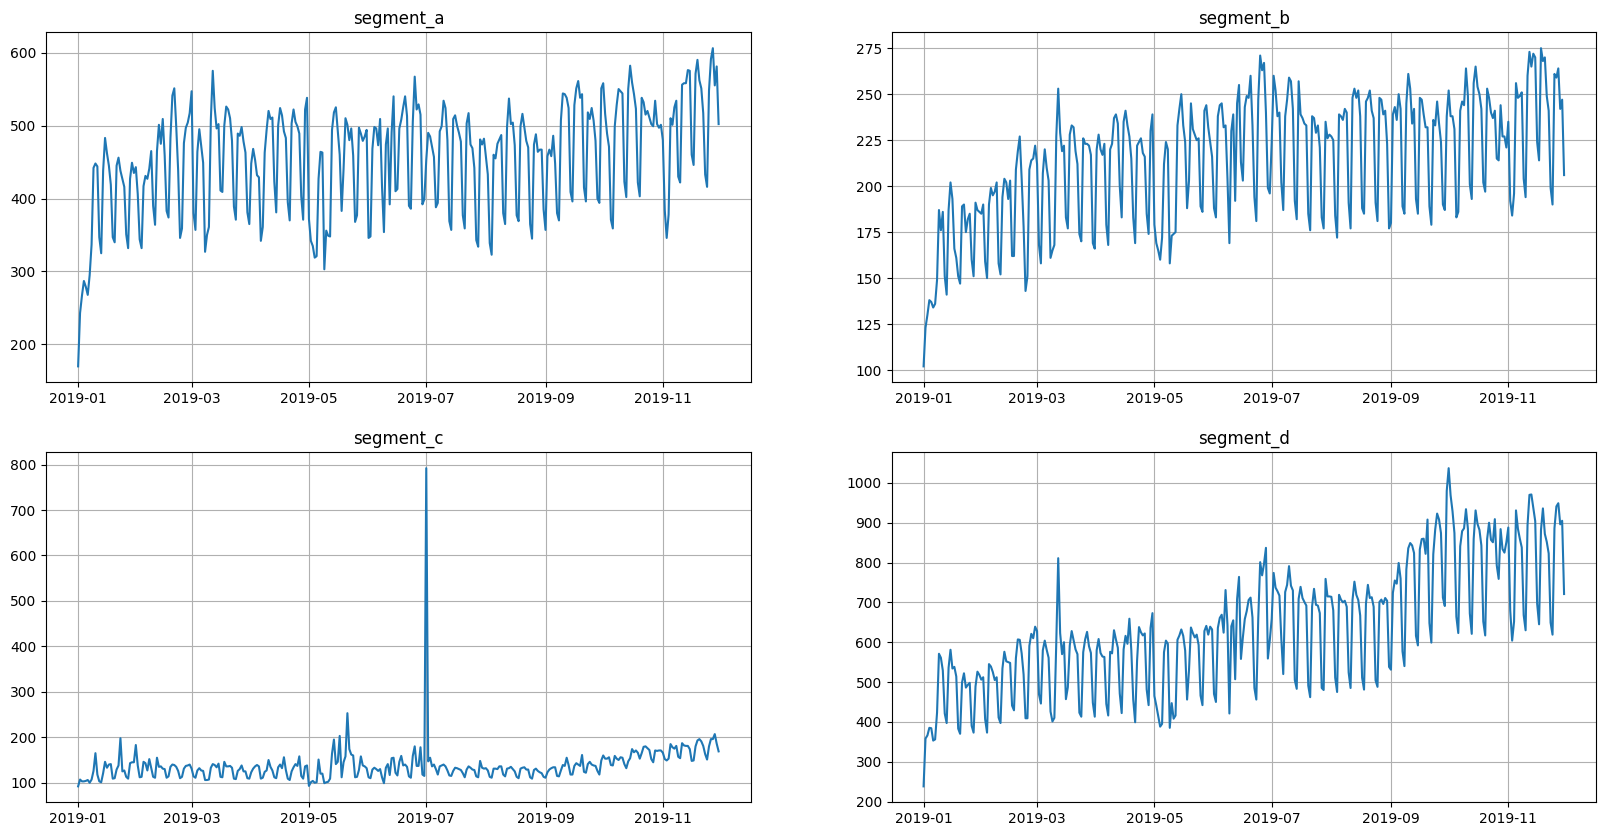

In [15]:
ts.plot()

Let's check that our implementations are equivalent

In [16]:
bounds_multi_segment = FloorCeilMultiSegmentTransform(in_column="target", floor=150, ceil=600)
bounds_per_segment = FloorCeilMultiSegmentTransform(in_column="target", floor=150, ceil=600)

df_per_segment = bounds_per_segment.fit_transform(deepcopy(ts)).to_pandas()
df_multi_segment = bounds_multi_segment.fit_transform(deepcopy(ts)).to_pandas()
pd.testing.assert_frame_equal(df_per_segment, df_multi_segment)

Fine, then we can check out the work of any of them

In [17]:
ts.fit_transform([bounds_multi_segment])

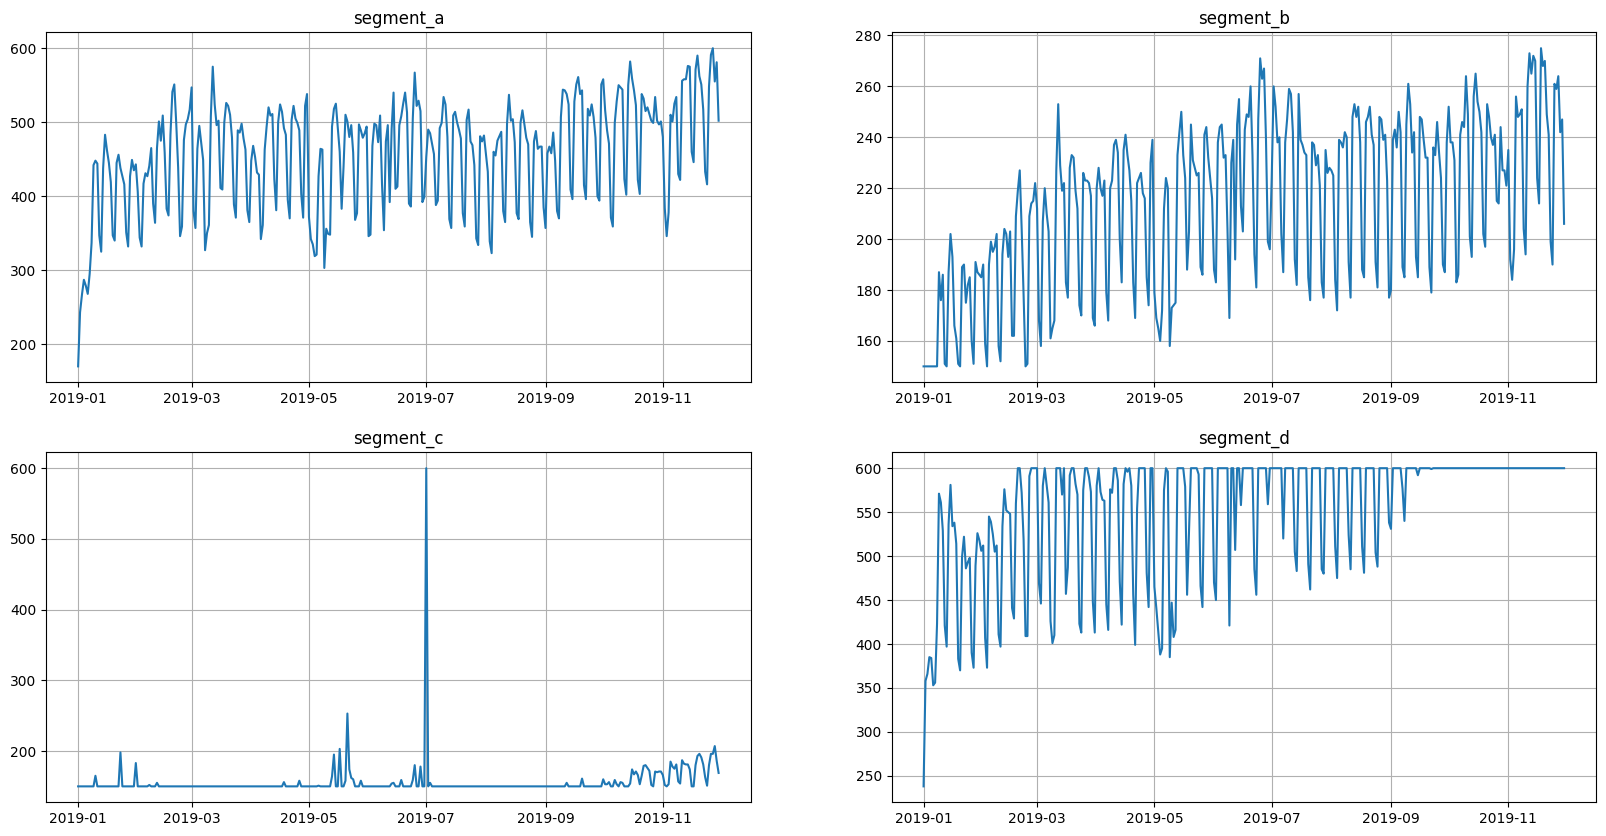

In [18]:
ts.plot()

Returning to the original values

In [19]:
ts.inverse_transform([bounds_multi_segment])

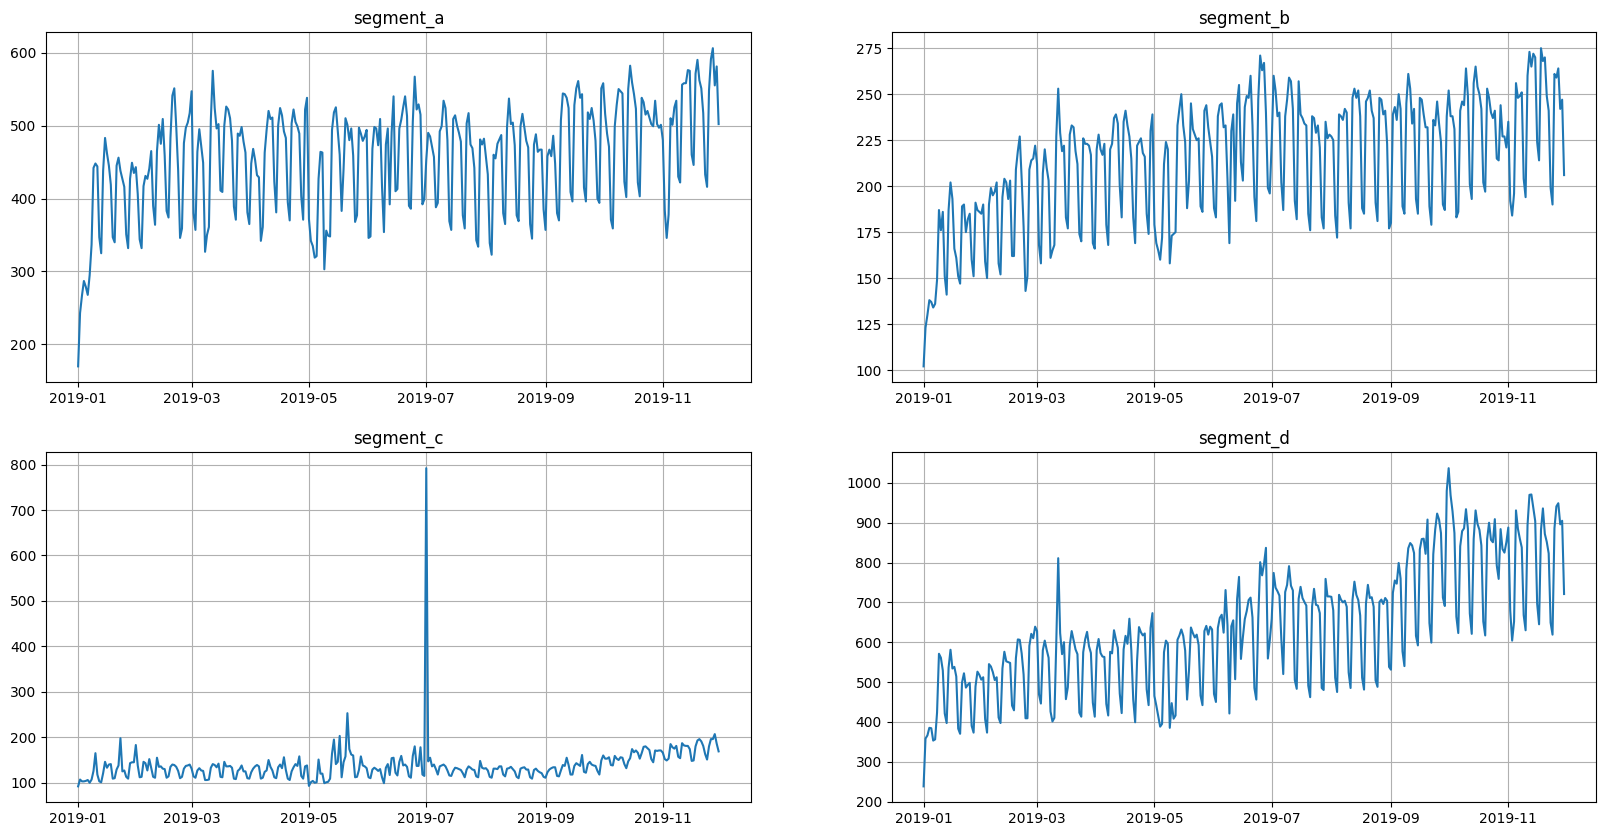

In [20]:
ts.plot()

Everything seems to be working correctly. Remember to write the necessary [tests](https://github.com/tinkoff-ai/etna/tree/master/tests) before adding a new transform to the library.

## 3. Custom Model <a class="anchor" id="chapter3"></a>

If you could not find a suitable model among the [ready-made ones](https://github.com/tinkoff-ai/etna/tree/master/etna/models), then you can create your own.

In this example we will try to add model based on `lightgbm` package.

In [21]:
!pip install lightgbm -q


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


### 3.1 Creating a new model from scratch <a class="anchor" id="section_3_1"></a>

First, let's look at creating a new model from scratch. First of all, we should choose our base class. There are:

* `NonPredictionIntervalContextIgnorantAbstractModel`: model can't generate prediction intervals and doesn't require context to make predictions,
* `NonPredictionIntervalContextRequiredAbstractModel`: model can't generate prediction intervals and requires context to make predictions,
* `PredictionIntervalContextIgnorantAbstractModel`: model can generate prediction intervals and doesn't require context to make predictions,
* `PredictionIntervalContextRequiredAbstractModel`: model can generate prediction intervals and requires context to make predictions.

These classes have different signatures for `forecast` and `predict` methods depending on their name. 

* All signatures accept `ts: TSDataset` parameter for making prediction and `return_components: bool`, that
denotes whether to estimate decomposition for predictions.
* If a model can generate prediction intervals it also accepts `prediction_interval: bool` and `quantiles: Sequence[float]` parameters.
* If a model requires context it also accepts `prediction_size: int` parameter, that is required to distinguish history context from points we want to make prediction on.

Let's make some clarifications about the context. It is a part of a dataset before prediction points that is necessary for making forecasts. It is necessary for models that in its core use previous points to make predictions into the future. The example is `etna.models.NaiveMode(lag=1)` that uses last point to predict the next.

Ok, what about model based on `lightgbm`? This model doesn't require context and we will make implementation that doesn't generate prediction intervals. Also, this section shows how one can implement prediction decomposition.

In [22]:
from lightgbm import LGBMRegressor

from etna.models import NonPredictionIntervalContextIgnorantAbstractModel

Let's look at implementation.

In [23]:
class LGBMModel(NonPredictionIntervalContextIgnorantAbstractModel):
    def __init__(
        self,
        boosting_type="gbdt",
        num_leaves=31,
        max_depth=-1,
        learning_rate=0.1,
        n_estimators=100,
        **kwargs,
    ):
        self.boosting_type = boosting_type
        self.num_leaves = num_leaves
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.kwargs = kwargs
        self.model = LGBMRegressor(
            boosting_type=self.boosting_type,
            num_leaves=self.num_leaves,
            max_depth=self.max_depth,
            learning_rate=self.learning_rate,
            n_estimators=self.n_estimators,
            **self.kwargs,
        )

    def fit(self, ts: TSDataset) -> "LGBMModel":
        """Fit model.

        Parameters
        ----------
        ts:
            Dataset with features

        Returns
        -------
        :
            Model after fit
        """
        df = ts.to_pandas(flatten=True)
        df = df.dropna()
        features = df.drop(columns=["timestamp", "segment", "target"])
        self._categorical = features.select_dtypes(include=["category"]).columns.to_list()
        target = df["target"]
        self.model.fit(X=features, y=target, categorical_feature=self._categorical)

    def forecast(self, ts: TSDataset, return_components: bool = False) -> TSDataset:
        """Make predictions.
        Prediction decomposition is based on SHAP values for LGBM.

        Parameters
        ----------
        ts:
            Dataset with features
        return_components:
            If True additionally returns prediction components

        Returns
        -------
        :
            Dataset with predictions
        """
        horizon = ts.size()[0]
        df = ts.to_pandas(flatten=True)
        features = df.drop(columns=["timestamp", "segment", "target"])

        y_flat = self.model.predict(features)

        y = y_flat.reshape(-1, horizon).T
        ts._df.loc[:, pd.IndexSlice[:, "target"]] = y

        if return_components:
            ts = self.forecast_components(ts=ts)

        return ts

    def forecast_components(self, ts: TSDataset) -> TSDataset:
        """Estimate prediction decomposition using SHAP values.

        Parameters
        ----------
        ts:
            Dataset with features

        Returns
        -------
        :
            Dataset with predictions
        """
        df = ts.to_pandas(flatten=True)
        features = df.drop(columns=["timestamp", "segment", "target"])

        # estimate SHAP values for prediction decomposition
        shap_values = self.model.predict(features, pred_contrib=True)

        # encapsulate expected contribution into components
        components = shap_values[:, :-1] + shap_values[:, -1, np.newaxis] / (shap_values.shape[1] - 1)

        # components names should start with prefix `target_component_`
        component_names = [f"target_component_{name}" for name in features.columns]

        components_df = pd.DataFrame(data=components, columns=component_names)
        components_df["timestamp"] = df["timestamp"]
        components_df["segment"] = df["segment"]
        components_df = TSDataset.to_dataset(df=components_df)

        # adding estimated components to dataset with predictions
        ts.add_target_components(target_components_df=components_df)

        return ts

    def predict(self, ts: TSDataset, return_components: bool = False) -> TSDataset:
        """Make predictions.

        Parameters
        ----------
        ts:
            Dataset with features
        return_components:
            If True additionally returns prediction components

        Returns
        -------
        :
            Dataset with predictions
        """
        return self.forecast(ts=ts, return_components=return_components)

    def get_model(self) -> LGBMRegressor:
        """Get internal lightgbm model.

        Returns
        -------
        :
            lightgbm model.
        """
        return self.model

Let's test it.

In [24]:
HORIZON = 31

In [25]:
trend = LinearTrendTransform(in_column="target")
lags = LagTransform(in_column="target", lags=list(range(31, 96, 1)), out_column="lag")
date_flags = DateFlagsTransform(
    day_number_in_week=True,
    day_number_in_month=True,
    week_number_in_month=True,
    week_number_in_year=True,
    month_number_in_year=True,
    year_number=True,
    special_days_in_week=[5, 6],
    out_column="dateflag",
)
segment_encoder = SegmentEncoderTransform()

transforms = [
    trend,
    lags,
    date_flags,
    segment_encoder,
]

In [26]:
model = LGBMModel(random_state=42, verbosity=-1)
pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)
metrics_df, forecast_df, _ = pipeline.backtest(ts=ts, metrics=[MAE()], n_folds=3)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.9s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    2.7s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


Let's look at the results.

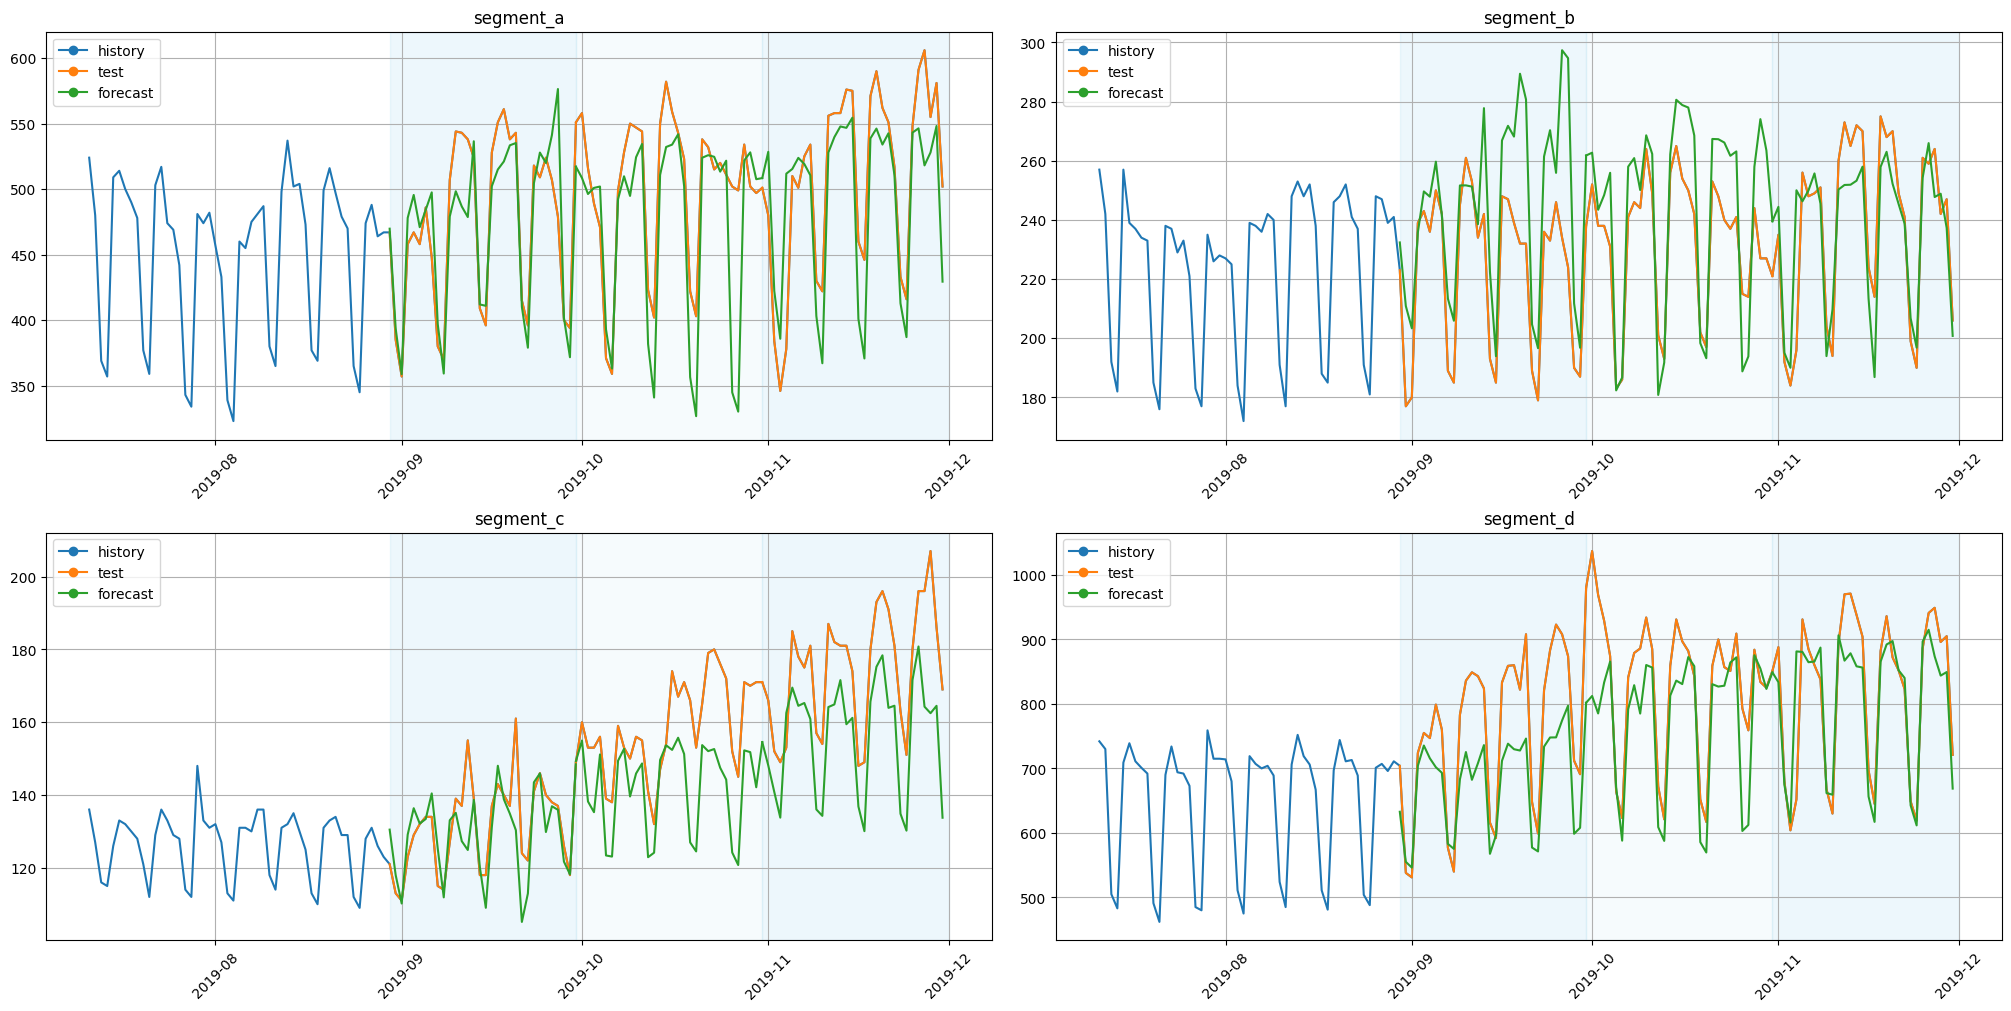

In [27]:
plot_backtest(forecast_df=forecast_df, ts=ts, history_len=50)

As we can see, predictions make sense.

Let's create a pipeline with only lag features to show how prediction components could be estimated and visualised.

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    1.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    1.7s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


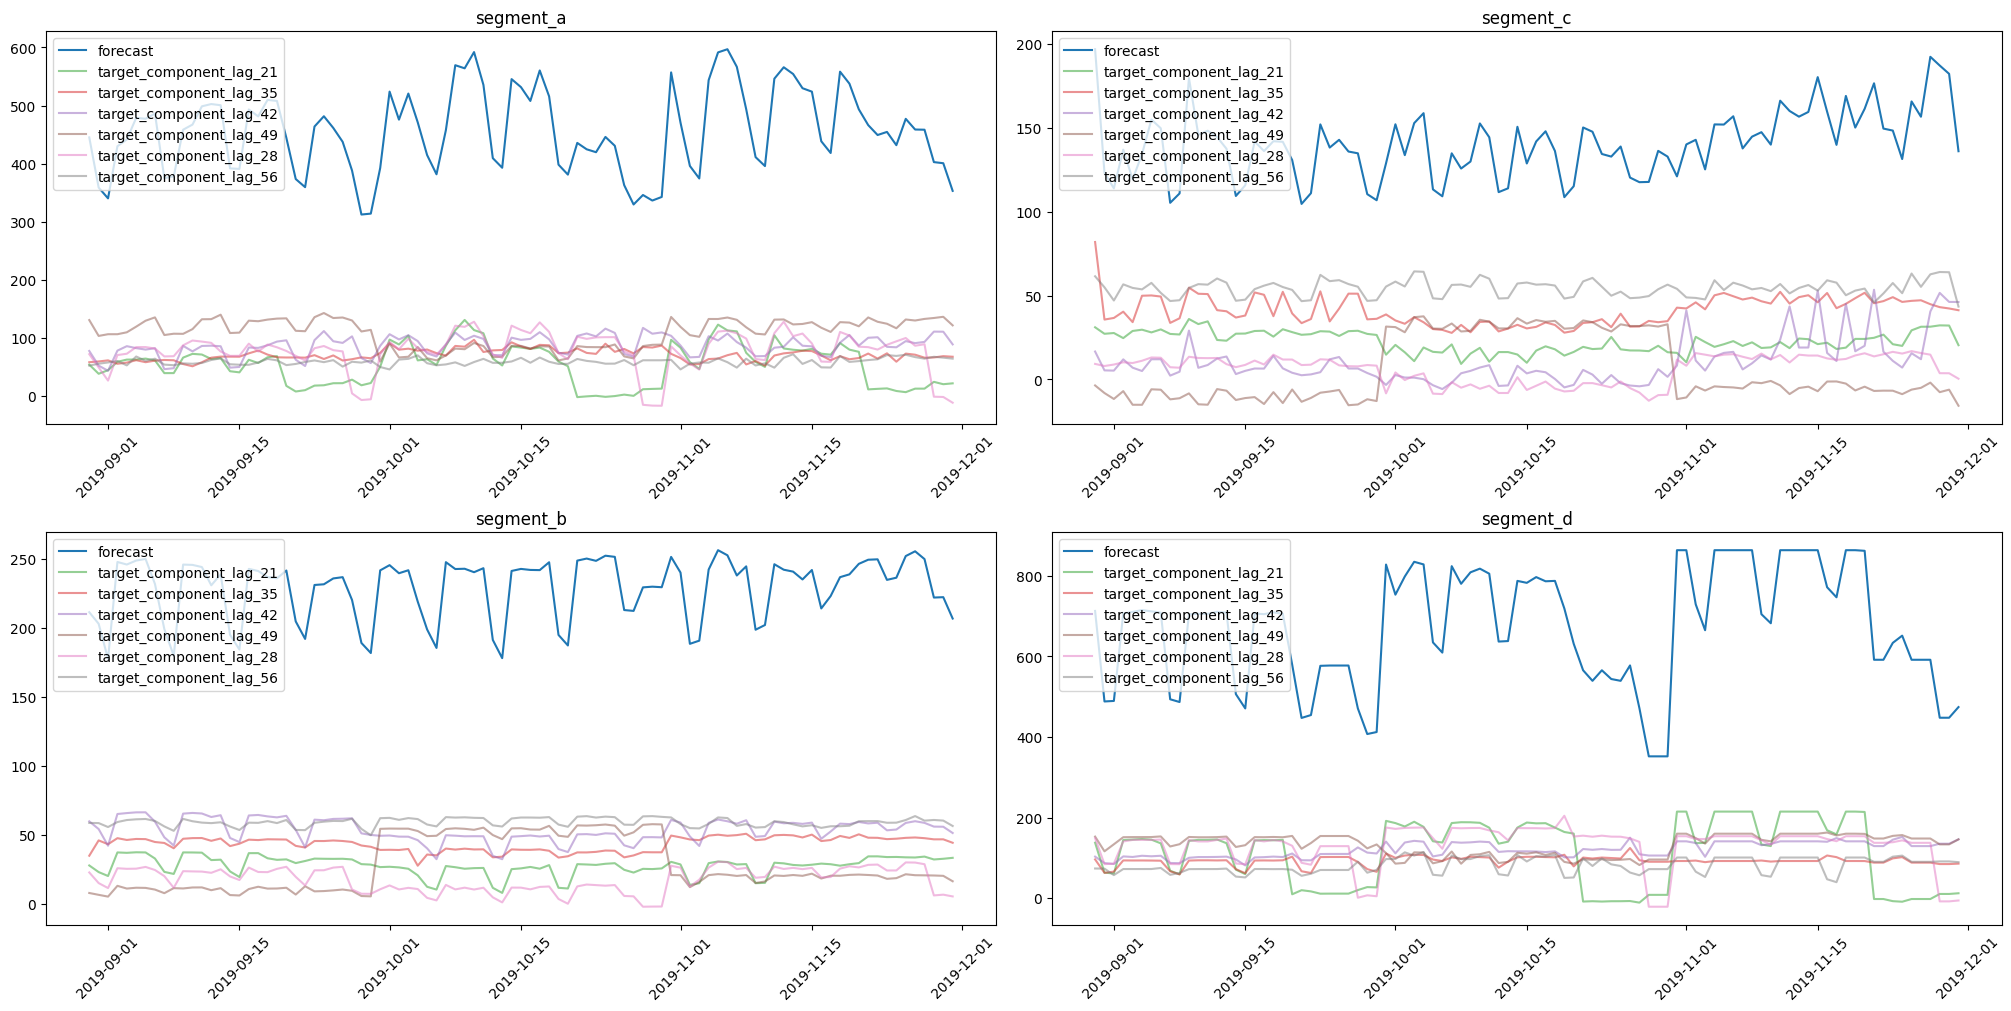

In [28]:
from etna.analysis.forecast import plot_forecast_decomposition

ts = deepcopy(init_ts)

model = LGBMModel(random_state=42, verbosity=-1)
pipeline = Pipeline(
    transforms=[
        LagTransform(in_column="target", lags=list(range(21, 57, 7)), out_column="lag"),
    ],
    model=model,
    horizon=HORIZON,
)

_, forecast_df, _ = pipeline.backtest(ts=ts, metrics=[MAE()], n_folds=3, forecast_params={"return_components": True})

plot_forecast_decomposition(forecast_ts=TSDataset(df=forecast_df, freq="D"), mode="joint", columns_num=2)

### 3.2 Creating a new model using sklearn interface <a class="anchor" id="section_3_2"></a>

Now let's create our model by leveraging already existing etna classes: 

* `etna.models.SklearnPerSegmentModel`: accepts sklearn-like model and creates etna-model that fits one model per each segment.
* `etna.models.SklearnMultiSegmentModel`: accepts sklearn-like model and creates etna-model that fits one model on entire dataset & mdash; it is that we implemented in a section above.

In [29]:
from etna.models import SklearnMultiSegmentModel
from etna.models import SklearnPerSegmentModel

First, let's implement etna-model that fits separate model per each segment.

In [30]:
class LGBMPerSegmentModel(SklearnPerSegmentModel):
    def __init__(
        self,
        boosting_type="gbdt",
        num_leaves=31,
        max_depth=-1,
        learning_rate=0.1,
        n_estimators=100,
        **kwargs,
    ):
        self.boosting_type = boosting_type
        self.num_leaves = num_leaves
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.kwargs = kwargs
        model = LGBMRegressor(
            boosting_type=self.boosting_type,
            num_leaves=self.num_leaves,
            max_depth=self.max_depth,
            learning_rate=self.learning_rate,
            n_estimators=self.n_estimators,
            **self.kwargs,
        )
        super().__init__(regressor=model)


class LGBMMultiSegmentModel(SklearnMultiSegmentModel):
    def __init__(
        self,
        boosting_type="gbdt",
        num_leaves=31,
        max_depth=-1,
        learning_rate=0.1,
        n_estimators=100,
        **kwargs,
    ):
        self.boosting_type = boosting_type
        self.num_leaves = num_leaves
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.kwargs = kwargs
        model = LGBMRegressor(
            boosting_type=self.boosting_type,
            num_leaves=self.num_leaves,
            max_depth=self.max_depth,
            learning_rate=self.learning_rate,
            n_estimators=self.n_estimators,
            **self.kwargs,
        )
        super().__init__(regressor=model)

Let's try to recreate results of `LGBMModel` using `LGBMMultiSegmentModel`.

In [31]:
model = LGBMMultiSegmentModel(random_state=42, verbosity=-1)
pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)
metrics_df_multi_segment, forecast_df, _ = pipeline.backtest(ts=ts, metrics=[MAE()], n_folds=3)

[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    2.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    3.0s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.4s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.8s
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done   3 tasks      | elapsed:    0.0s


Let's look at the results.

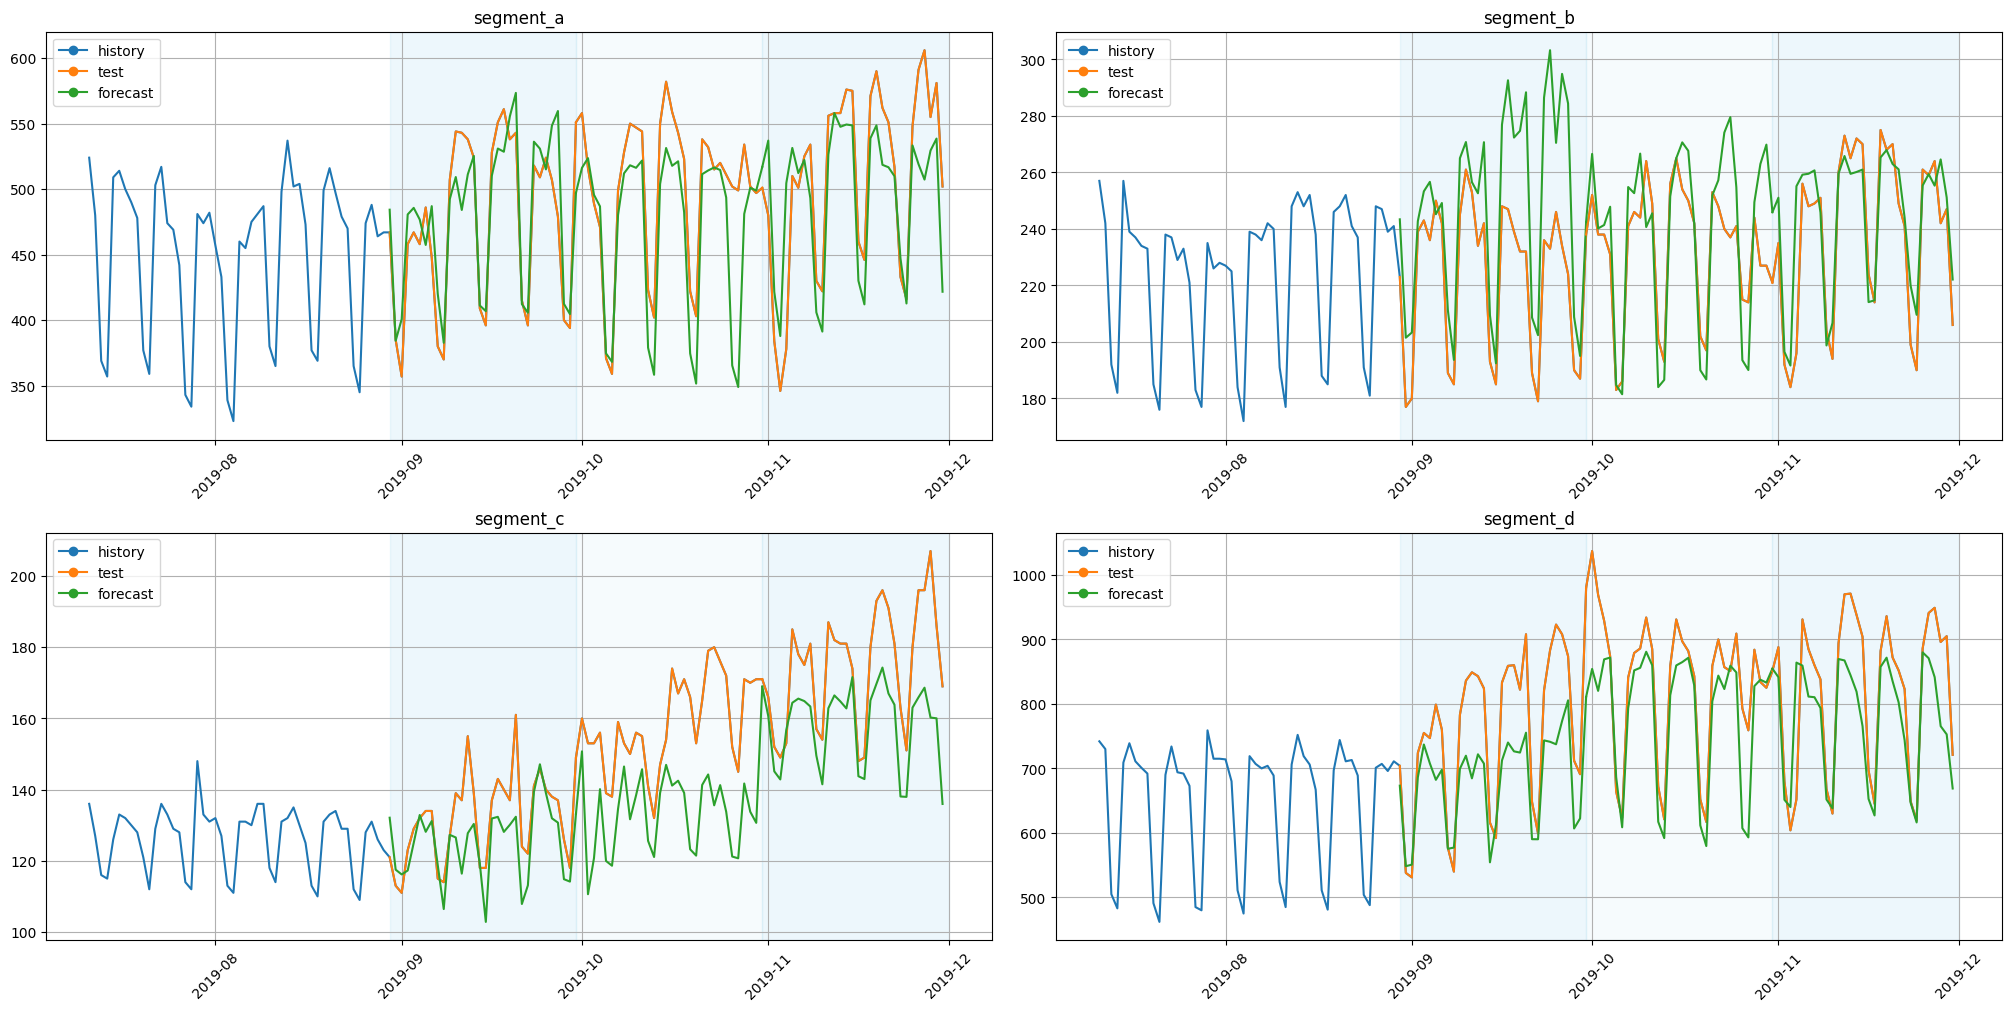

In [32]:
plot_backtest(forecast_df=forecast_df, ts=ts, history_len=50)

As we can see, the results are a little bit different. Let's check this manually by looking at the values.

In [33]:
metrics_df.head()

,segment,MAE,fold_number
0,segment_a,22.633598,0
0,segment_a,35.034894,1
0,segment_a,35.003214,2
1,segment_b,22.285198,0
1,segment_b,16.546921,1


In [34]:
metrics_df_multi_segment.head()

,segment,MAE,fold_number
0,segment_a,23.121324,0
0,segment_a,34.062925,1
0,segment_a,34.721675,2
1,segment_b,25.587469,0
1,segment_b,13.960903,1


Why do we see this difference? In `LGBMModel` we have a special handling of categorical features, but in `LGBMMultiSegmentModel` we doesn't have it, because `etna.models.SklearnMultiSegmentModel` doesn't implement this logic with categorical features.

As you can see, `etna.models.SklearnPerSegmentModel` and `etna.models.SklearnMultiSegmentModel` have some limitations, but they should cover a lot of cases.

This raises a question: what if I want to implement per-segment logic manually with handling categorical features like in `LGBMModel`? A good reference for such a task will be the implementations of `etna.models.CatBoostPerSegmentModel` and `etna.models.CatBoostMultiSegmentModel`. There we use special mixins for per-segment/multi-segment logic.

If you want to add you model to the library don't forget to write the necessary tests and documentation. Good luck!